In [1]:
import pandas as pd 
import numpy as np

In [2]:
X_train=pd.read_csv("C://Users//ankit//Desktop//ml-005//RAG project//mnist_train.csv")

In [3]:
Y_train=X_train.iloc[:,0]
X_train=X_train.iloc[:,1:]

In [4]:
X_train.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train.shape,Y_train.shape

((59999, 784), (59999,))

In [6]:
Y_train.head()

0    0
1    4
2    1
3    9
4    2
Name: 5, dtype: int64

In [7]:
# Normalize pixel values to [0,1]
X_train = X_train.values / 255.0
Y_train = Y_train.values.astype(int)



In [8]:
Y_train

array([0, 4, 1, ..., 5, 6, 8], shape=(59999,))

In [9]:
import numpy as np

class ANN:
    def __init__(self):
        self.W1 = []
        self.W2 = []
        self.b1 = []
        self.b2 = []
        self.input_n = 784

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        exp_z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # for stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def initialize_weights_and_biases(self, input_dim, hidden_dim, output_dim):
        self.W1 = np.random.uniform(low=-1, high=1, size=(input_dim, hidden_dim))
        self.b1 = np.random.uniform(low=-1, high=1, size=(hidden_dim,))
        self.W2 = np.random.uniform(low=-1, high=1, size=(hidden_dim, output_dim))
        self.b2 = np.random.uniform(low=-1, high=1, size=(output_dim,))

    def forward_prop(self, X):
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = self.relu(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def get_class_labels(self, A2):
        return np.argmax(A2, axis=1)

    def gradient_calcus(self, A2, A1, Z1, X, Y):
        N = X.shape[0]

        dz2 = A2 - Y
        dw2 = np.dot(A1.T, dz2) / N
        db2 = np.sum(dz2, axis=0) / N

        dA1 = np.dot(dz2, self.W2.T)
        dZ1 = dA1 * (Z1 > 0).astype(float)

        dW1 = np.dot(X.T, dZ1) / N
        db1 = np.sum(dZ1, axis=0) / N

        return dw2, db2, dW1, db1

    def backpropagation(self, X, Y, learning_rate=0.01):
        Z1, A1, Z2, A2 = self.forward_prop(X)
        dw2, db2, dW1, db1 = self.gradient_calcus(A2, A1, Z1, X, Y)

        self.W2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def computeloss(self, Y_pred, Y_true):
        eps = 1e-15
        Y_pred_clipped = np.clip(Y_pred, eps, 1 - eps)
        loss = -np.mean(np.sum(Y_true * np.log(Y_pred_clipped), axis=1))
        return loss

    def accuracy(self, Y_true, A2):
        y_pred_labels = self.get_class_labels(A2)
        y_true_labels = np.argmax(Y_true, axis=1)
        return np.mean(y_pred_labels == y_true_labels)



    def predic(self, X_test, y_test):
        _, _, _, A2 = self.forward_prop(X_test)
        return self.get_class_labels(A2)

        
    def train(self, X_train, Y_train, epochs=10, batch_size=32, learning_rate=0.01):
        N = X_train.shape[0]
        losses = []
        accuracies = []

        for epoch in range(epochs):
            indices = np.arange(N)
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            Y_train_shuffled = Y_train[indices]

            epoch_loss = 0
            num_batches = 0

            for start_idx in range(0, N, batch_size):
                end_idx = min(start_idx + batch_size, N)
                X_batch = X_train_shuffled[start_idx:end_idx]
                Y_batch = Y_train_shuffled[start_idx:end_idx]

                # Forward pass
                Z1, A1, Z2, A2 = self.forward_prop(X_batch)

                # One-hot encode true labels
                one_hot_Y = np.zeros_like(A2)
                one_hot_Y[np.arange(len(Y_batch)), Y_batch] = 1

                # Loss
                loss = self.computeloss(A2, one_hot_Y)
                epoch_loss += loss

                # Backprop
                self.backpropagation(X_batch, one_hot_Y, learning_rate)

                num_batches += 1

            # After epoch
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)

            # Accuracy on full training set (optional: could use val set)
            _, _, _, A2_train = self.forward_prop(X_train)
            one_hot_Y_full = np.zeros_like(A2_train)
            one_hot_Y_full[np.arange(N), Y_train] = 1
            acc = self.accuracy(one_hot_Y_full, A2_train)
            accuracies.append(acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

        return losses, accuracies



In [10]:
model1= ANN()
model1.initialize_weights_and_biases(input_dim=784, hidden_dim=10, output_dim=10)
losses = model1.train(X_train, Y_train, epochs=20, batch_size=64, learning_rate=0.01)

Epoch 1/20, Loss: 2.5325, Accuracy: 0.3698
Epoch 2/20, Loss: 1.6284, Accuracy: 0.4787
Epoch 3/20, Loss: 1.3512, Accuracy: 0.5663
Epoch 4/20, Loss: 1.1710, Accuracy: 0.6211
Epoch 5/20, Loss: 1.0518, Accuracy: 0.6579
Epoch 6/20, Loss: 0.9660, Accuracy: 0.6882
Epoch 7/20, Loss: 0.9004, Accuracy: 0.7083
Epoch 8/20, Loss: 0.8465, Accuracy: 0.7275
Epoch 9/20, Loss: 0.8016, Accuracy: 0.7441
Epoch 10/20, Loss: 0.7625, Accuracy: 0.7583
Epoch 11/20, Loss: 0.7286, Accuracy: 0.7669
Epoch 12/20, Loss: 0.6991, Accuracy: 0.7802
Epoch 13/20, Loss: 0.6731, Accuracy: 0.7871
Epoch 14/20, Loss: 0.6502, Accuracy: 0.7960
Epoch 15/20, Loss: 0.6304, Accuracy: 0.8034
Epoch 16/20, Loss: 0.6110, Accuracy: 0.8099
Epoch 17/20, Loss: 0.5945, Accuracy: 0.8154
Epoch 18/20, Loss: 0.5788, Accuracy: 0.8215
Epoch 19/20, Loss: 0.5644, Accuracy: 0.8253
Epoch 20/20, Loss: 0.5515, Accuracy: 0.8292


In [11]:
X_test=pd.read_csv("C://Users//ankit//Desktop//ml-005//RAG project//mnist_test.csv")

In [12]:
Y_test=X_test.iloc[:,0]
X_test=X_test.iloc[:,1:]/255

In [13]:
Y_test

0       2
1       1
2       0
3       4
4       1
       ..
9994    2
9995    3
9996    4
9997    5
9998    6
Name: 7, Length: 9999, dtype: int64

In [14]:
Y_test=Y_test.values.astype(int)

In [15]:
Y_test

array([2, 1, 0, ..., 4, 5, 6], shape=(9999,))

In [16]:
Y_pred=model1.predic(X_test,Y_test)

In [17]:
output1 = pd.DataFrame({
    'Predicted': Y_pred,
    'Actual': Y_test,
    'Result': Y_pred == Y_test
})

print("model with 10 neurons in hidden layer:")
print(f"Test Accuracy: {np.mean(output1['Result']):.4f}")


model with 10 neurons in hidden layer:
Test Accuracy: 0.8287


In [18]:
model2= ANN()
model2.initialize_weights_and_biases(input_dim=784, hidden_dim=64, output_dim=10)
losses = model2.train(X_train, Y_train, epochs=20, batch_size=64, learning_rate=0.01)

Epoch 1/20, Loss: 3.2796, Accuracy: 0.7538
Epoch 2/20, Loss: 1.2013, Accuracy: 0.8033
Epoch 3/20, Loss: 0.8748, Accuracy: 0.8268
Epoch 4/20, Loss: 0.7164, Accuracy: 0.8410
Epoch 5/20, Loss: 0.6205, Accuracy: 0.8518
Epoch 6/20, Loss: 0.5559, Accuracy: 0.8591
Epoch 7/20, Loss: 0.5100, Accuracy: 0.8664
Epoch 8/20, Loss: 0.4753, Accuracy: 0.8727
Epoch 9/20, Loss: 0.4482, Accuracy: 0.8772
Epoch 10/20, Loss: 0.4263, Accuracy: 0.8823
Epoch 11/20, Loss: 0.4084, Accuracy: 0.8871
Epoch 12/20, Loss: 0.3928, Accuracy: 0.8893
Epoch 13/20, Loss: 0.3798, Accuracy: 0.8924
Epoch 14/20, Loss: 0.3684, Accuracy: 0.8957
Epoch 15/20, Loss: 0.3582, Accuracy: 0.8973
Epoch 16/20, Loss: 0.3494, Accuracy: 0.8993
Epoch 17/20, Loss: 0.3413, Accuracy: 0.9007
Epoch 18/20, Loss: 0.3335, Accuracy: 0.9036
Epoch 19/20, Loss: 0.3270, Accuracy: 0.9057
Epoch 20/20, Loss: 0.3206, Accuracy: 0.9071


In [46]:
Y_pred=model2.predic(X_test,Y_test)

In [47]:
output2 = pd.DataFrame({
    'Predicted': Y_pred,
    'Actual': Y_test,
    'Result': Y_pred == Y_test
})

print("model with 64 neurons in hidden layer:")
print(f"Test Accuracy: {np.mean(output2['Result']):.4f}")


model with 64 neurons in hidden layer:
Test Accuracy: 0.9050


predicted value: 2 Actual value 2


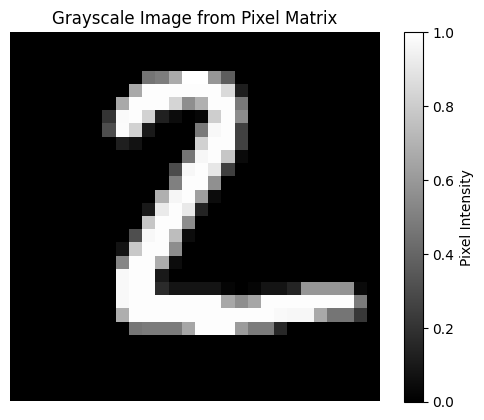

In [48]:
import matplotlib.pyplot as plt

one_sample = X_test.iloc[0].to_numpy()      # Get first sample, shape: (784,)
one_sample = one_sample  # Convert back to 0-255 scale if normalized
one_sample = one_sample.reshape(28, 28)  # Reshape for display
print(f"predicted value: {output2['Predicted'][0]} Actual value {output2['Actual'][0]}")
plt.imshow(one_sample, cmap='gray')
plt.title('Grayscale Image from Pixel Matrix')
plt.colorbar(label='Pixel Intensity')
plt.axis('off')
plt.show()
